## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 25, 15
# %matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer

In [3]:
!ls

AB_NYC_2019.csv  homework_6.ipynb


In [4]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [5]:
df.isna().sum()

neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = np.log1p(df_train['price'].values)
y_val = np.log1p(df_val['price'].values)
y_test = np.log1p(df_test['price'].values)

del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [9]:
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train.ravel())

DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(tree, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* **`room_type`**
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train.ravel())

y_pred_val_rf = rf.predict(X_val)

In [12]:
mean_squared_error(y_pred_val_rf, y_val, squared=False).round(3)

0.462

What's the RMSE of this model on validation?

* 0.059
* 0.259
* **0.459**
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [13]:
n_estimators_list = list(range(10, 201, 10))
rmse_list = []
for _ in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=_, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train.ravel())

    y_pred_val_rf = rf.predict(X_val)
    
    rmse_list.append(mean_squared_error(y_pred_val_rf, y_val, squared=False).round(3))

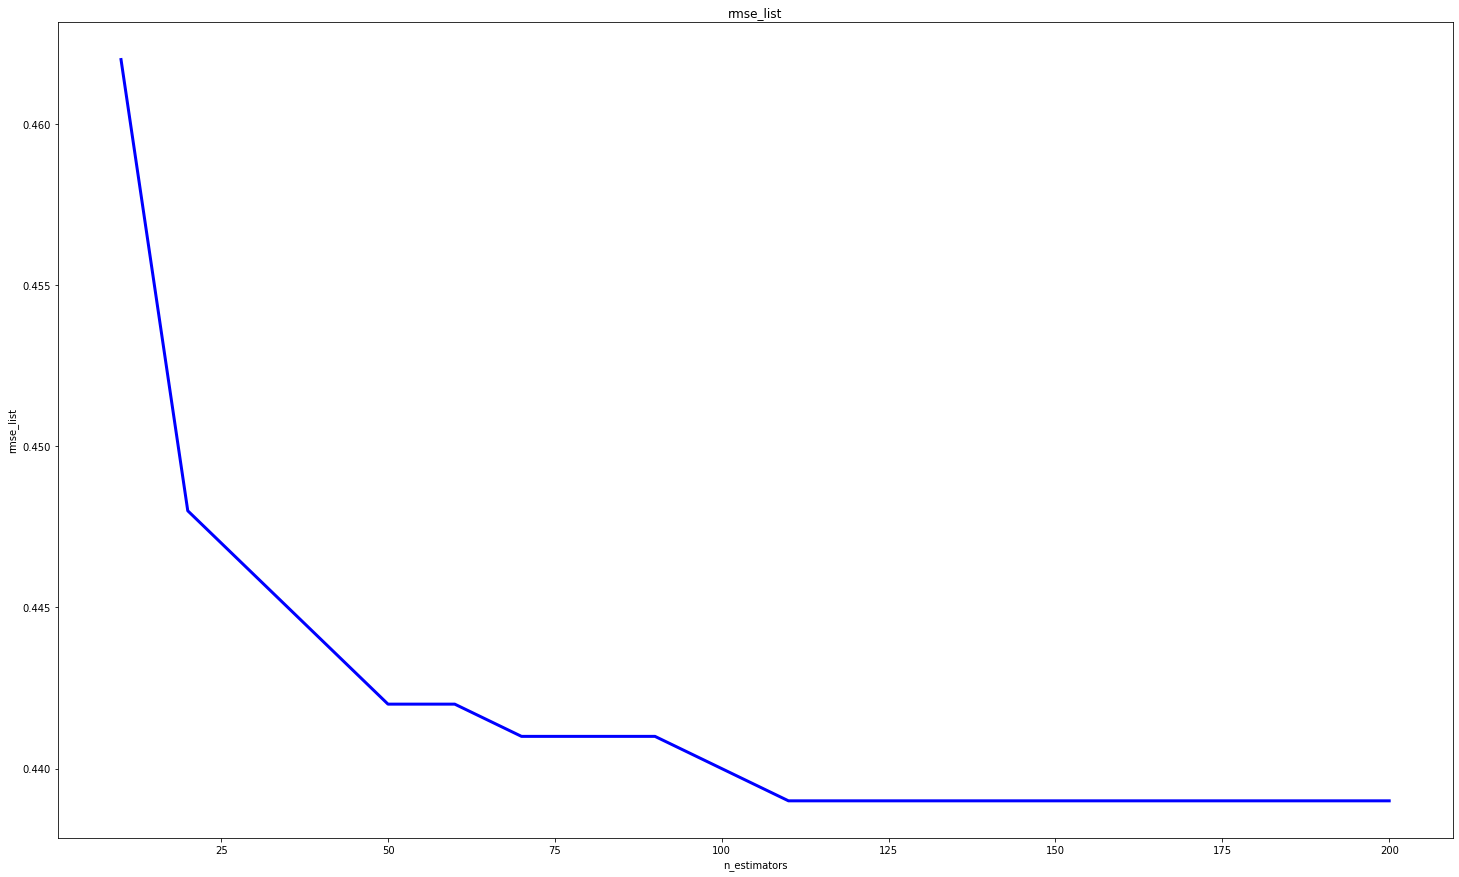

In [14]:
plt.plot(n_estimators_list, rmse_list, label='rmse', color='blue', linewidth=3)
plt.title('rmse_list')
plt.xlabel('n_estimators')
plt.ylabel('rmse_list')
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **120**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [15]:
n_estimators_list = list(range(10, 201, 10))
depth_list = [10, 15, 20, 25]
rmse_list = []

for depth in depth_list:
    print('depth =', depth)
    for _ in n_estimators_list:
        rf = RandomForestRegressor(n_estimators=_, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred_val_rf = rf.predict(X_val)
        _rmse = mean_squared_error(y_pred_val_rf, y_val, squared=False).round(3)

        rmse_list.append((depth, _, _rmse))

depth = 10
depth = 15
depth = 20
depth = 25


In [16]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(rmse_list, columns=columns)

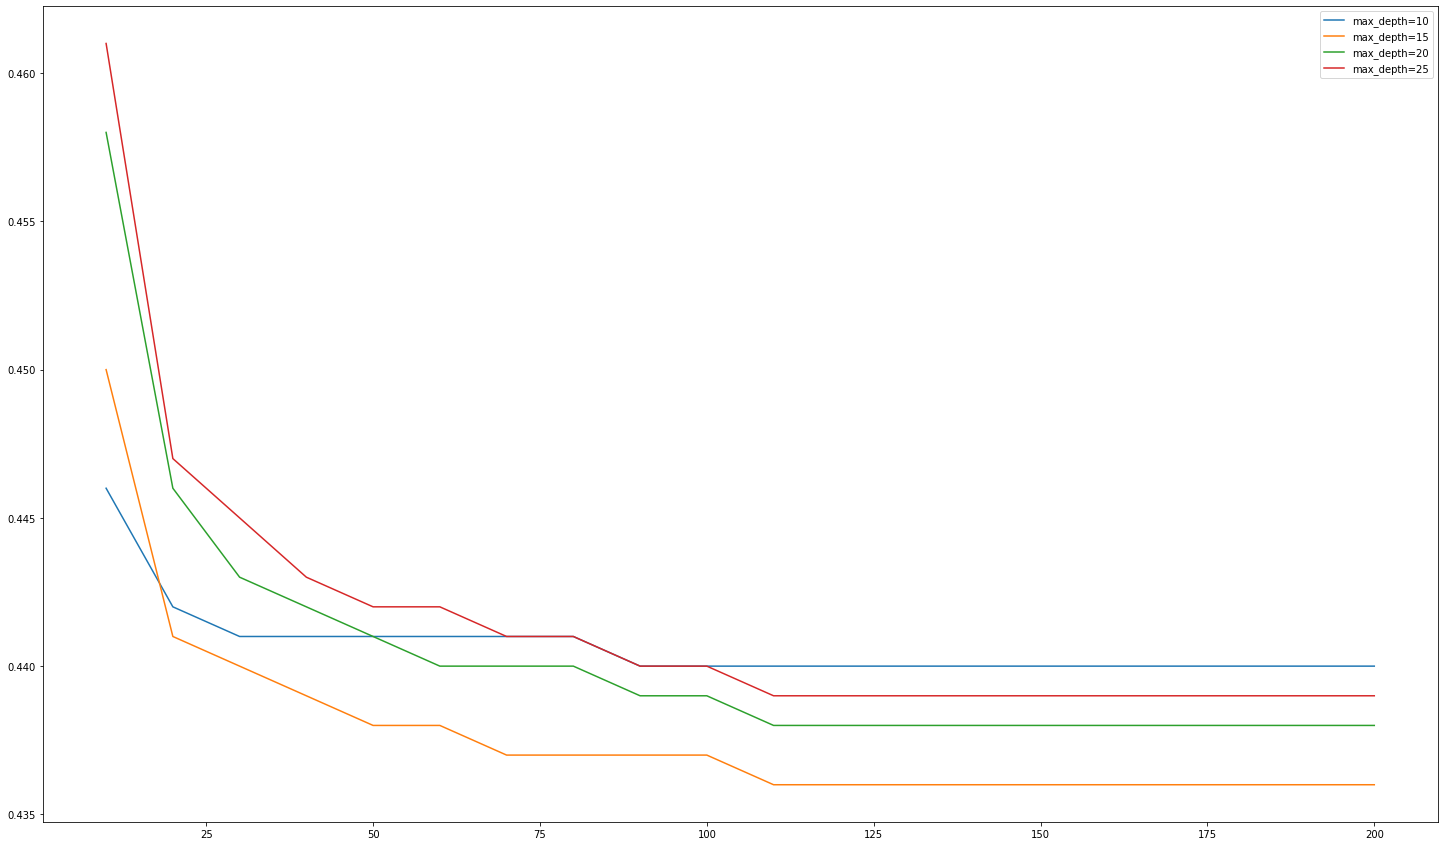

In [17]:
for d in depth_list:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* **15**
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [18]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
dv.feature_names_

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

In [20]:
sorted(list(zip(dv.feature_names_, rf.feature_importances_)), key=lambda x: x[1], reverse=True)

[('room_type=Entire home/apt', 0.3918981936917194),
 ('longitude', 0.154100959574963),
 ('latitude', 0.15277535379400203),
 ('availability_365', 0.07626394738694817),
 ('reviews_per_month', 0.054430387733031084),
 ('minimum_nights', 0.053251917646480185),
 ('number_of_reviews', 0.041594241500710276),
 ('neighbourhood_group=Manhattan', 0.034047271823485964),
 ('calculated_host_listings_count', 0.03010192548517814),
 ('room_type=Shared room', 0.005022841301586759),
 ('room_type=Private room', 0.004032027763645291),
 ('neighbourhood_group=Queens', 0.0011660990169743988),
 ('neighbourhood_group=Brooklyn', 0.0009659595374179875),
 ('neighbourhood_group=Bronx', 0.0002648458491617382),
 ('neighbourhood_group=Staten Island', 8.402789469553793e-05)]

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* **`room_type=Entire home/apt`**	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [21]:
# !pip install xgboost

In [22]:
import xgboost as xgb

In [23]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [24]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [25]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [26]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [27]:
scores = {}

#### eta = 0.3

In [28]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=1,
                  evals=watchlist)

In [29]:
scores[xgb_params['eta']] = parse_xgb_output(output)

#### eta = 0.1

In [30]:
%%capture output_01

xgb_params_01 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params_01, dtrain, num_boost_round=100, verbose_eval=1, evals=watchlist)

In [31]:
scores[xgb_params_01['eta']] = parse_xgb_output(output_01)

#### eta = 0.01

In [32]:
%%capture output_001

xgb_params_001 = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params_001, dtrain, num_boost_round=100, verbose_eval=1, evals=watchlist)

In [33]:
scores[xgb_params_001['eta']] = parse_xgb_output(output_001)

In [34]:
scores.keys()

dict_keys([0.3, 0.1, 0.01])

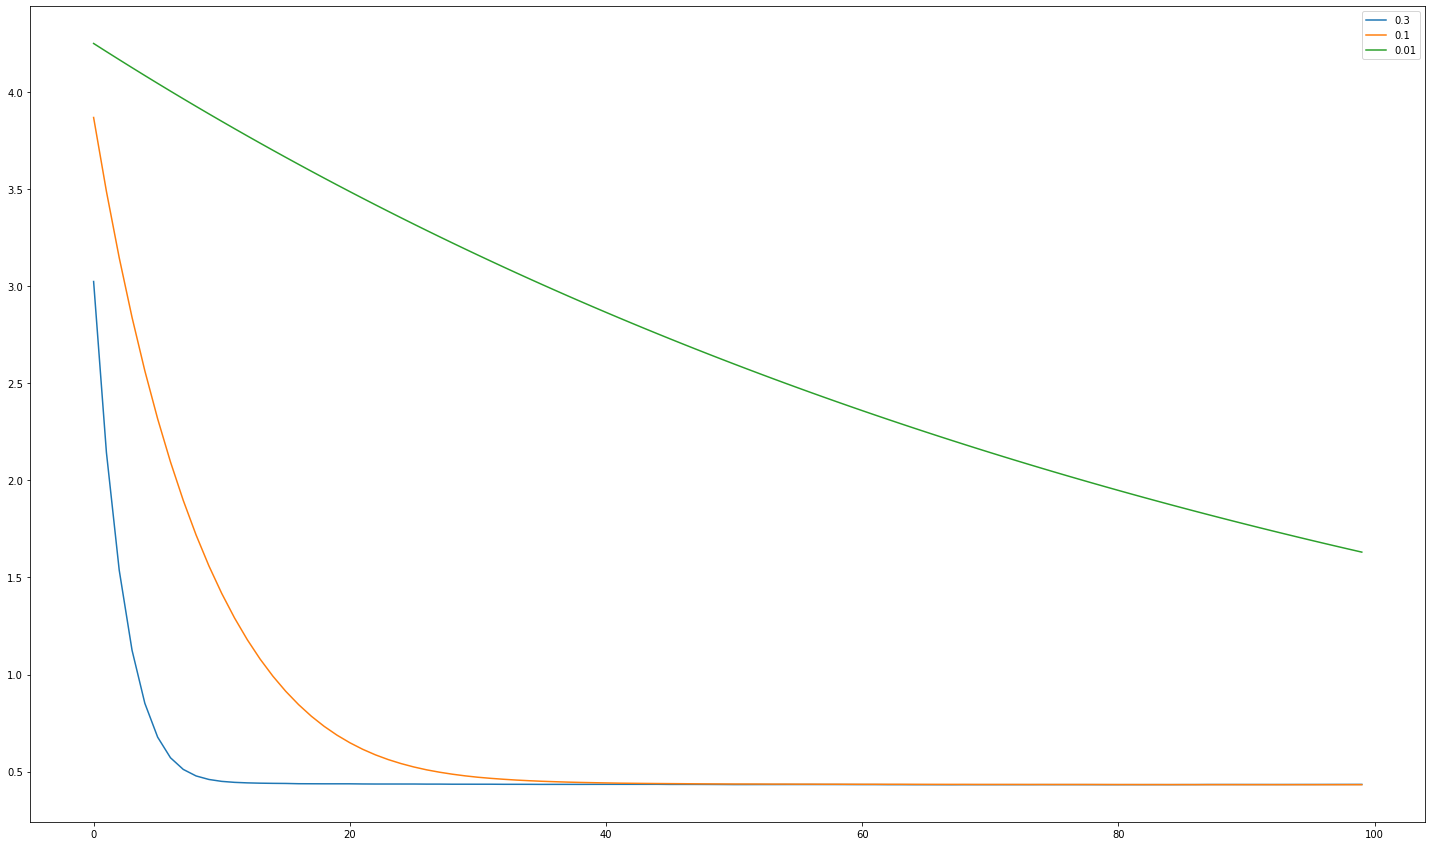

In [36]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.legend()

Now change `eta` first to `0.1` and then to `0.01`

What's the best eta?

* 0.3
* **0.1**
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

